In [1]:
import json
import os
import joblib
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE



from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score,roc_curve

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier



import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import fairlearn

In [3]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('comb_df.csv')

# Select the specified columns
selected_columns = [
    'id', 'name', 'sex', 'dob', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 
    'priors_count', 'c_case_number', 'c_charge_degree', 'c_charge_desc', 'c_arrest_date', 
    'c_offense_date', 'c_jail_in', 'is_recid'#, 'source'
]
df = df[selected_columns]

df.head()

,id,name,sex,dob,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_case_number,c_charge_degree,c_charge_desc,c_arrest_date,c_offense_date,c_jail_in,is_recid
0,6215,9141e91169c295318fcfe1455d5b3f62ab68398a5c02d3...,Female,1992-02-09,African-American,0,0,0,0,13011801CF10A,F,Retail Theft $300 1st Offense,NaN,2013-08-22,2013-08-22 07:13:26,False
1,6216,624ff2784da94426e6dd9bee644fe72e72629c5b906548...,Male,1993-09-09,Caucasian,0,0,1,1,13006949CF10A,F,arrest case no charge,2013-05-12,NaN,2013-05-15 10:31:31,False
2,6217,3987c8feeabf0cb9e960538f9eb749a8a6299ef265d493...,Male,1987-10-23,Other,0,0,0,0,13011964CF10A,F,Grand Theft in the 3rd Degree,NaN,2013-08-25,2013-08-25 01:21:23,False
3,6218,029a3fda0283710f8cc359e1a2f8ddc49015cb8db2458f...,Male,1993-01-27,Other,0,0,0,0,14003205MM10A,M,Battery,NaN,2014-02-24,2014-02-24 12:37:02,True
4,6219,846830aa3a8e034accdd1434df4bb862a02e3b84855072...,Male,1986-03-11,African-American,0,0,0,5,13002993CF10A,M,Aggravated Assault W/dead Weap,NaN,2013-02-27,2013-02-27 02:39:10,False


## Normal Model - No Fairness

Accuracy: 0.73
Precision: 0.76
Recall: 0.60
F1-Score: 0.67
ROC-AUC: 0.80
Confusion Matrix:
[[582 112]
 [228 346]]

Fairness metrics for sex:
Disparate Impact Ratio: 0.78
Equalized Odds Ratio: 0.42
True Positive Rate Difference: 0.03
False Positive Rate Difference: 0.11
Selection Rate Difference: 0.08

Fairness metrics for race:
Disparate Impact Ratio: 0.52
Equalized Odds Ratio: 0.30
True Positive Rate Difference: 0.15
False Positive Rate Difference: 0.17
Selection Rate Difference: 0.22

Fairness metrics for age_group:
Disparate Impact Ratio: 0.44
Equalized Odds Ratio: 0.22
True Positive Rate Difference: 0.18
False Positive Rate Difference: 0.21
Selection Rate Difference: 0.26

Fairness metrics for priors_count_bin:
Disparate Impact Ratio: 0.18
Equalized Odds Ratio: 0.04
True Positive Rate Difference: 0.47
False Positive Rate Difference: 0.60
Selection Rate Difference: 0.65

Disparate Impact Ratios by Sex:
Male: 1.05
Female: 0.82

Disparate Impact Ratios by Race:
African-American: 1.27


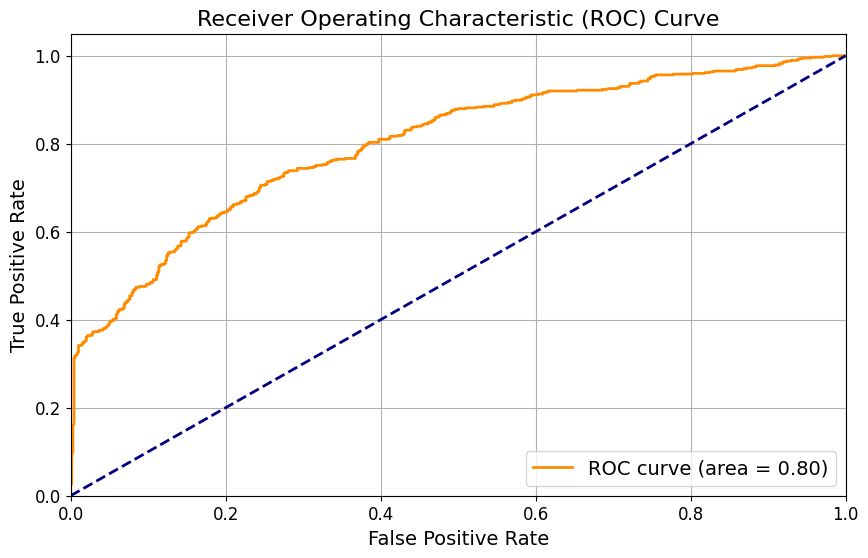

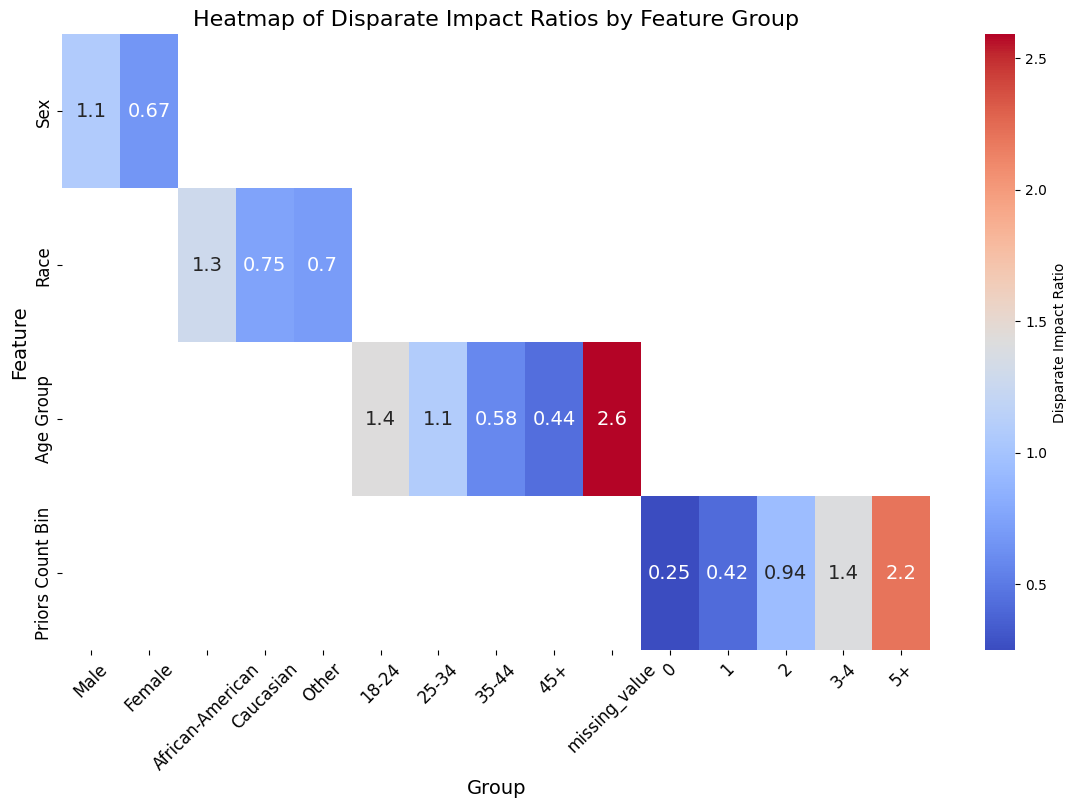

In [202]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio, true_positive_rate_difference, false_positive_rate_difference, selection_rate_difference
import pickle

# Define the frequency encoding function
def frequency_encoding(df, column):
    freq_encoding = df[column].value_counts(normalize=True)
    df[f'{column}_freq'] = df[column].map(freq_encoding)
    return df

# Define the preprocess_data function
def preprocess_data(df):
    df['dob'] = pd.to_datetime(df['dob'])
    df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])
    df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])
    df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])

    # Create unified_date
    df['unified_date'] = df['c_arrest_date'].combine_first(df['c_offense_date'])

    # Feature engineering
    df['age_jail'] = (df['c_jail_in'] - df['dob']).dt.days // 365
    df['age_arrest'] = (df['unified_date'] - df['dob']).dt.days // 365
    df['total_juv_crimes'] = df['juv_fel_count'] + df['juv_misd_count'] + df['juv_other_count']
    df['total_adult_crimes'] = df['priors_count'] - df['total_juv_crimes']

    # Frequency encoding for 'c_charge_desc'
    df = frequency_encoding(df, 'c_charge_desc')

    # Create age bins
    age_bins = [16, 25, 35, 45, 96]
    age_labels = ['16-24', '25-34', '35-44', '45+']
    df['age_group'] = pd.cut(df['age_jail'], bins=age_bins, labels=age_labels, right=False)

    # Create bins for priors_count
    priors_bins = [0, 1, 2, 3, 5, float('inf')]
    priors_labels = ['0', '1', '2', '3-4', '5+']
    df['priors_count_bin'] = pd.cut(df['priors_count'], bins=priors_bins, labels=priors_labels, right=False)

    # Extract more granular date features
    df['offense_month'] = df['c_offense_date'].dt.month
    df['offense_day_of_week'] = df['c_offense_date'].dt.dayofweek
    df['arrest_month'] = df['c_arrest_date'].dt.month
    df['arrest_day_of_week'] = df['c_arrest_date'].dt.dayofweek

    df['time_to_jail'] = (df['c_jail_in'] - df['c_offense_date']).dt.days
    df['race_priors_interaction'] = df['race'].astype(str) + '_' + df['priors_count_bin'].astype(str)
    df['jail_month'] = df['c_jail_in'].dt.month
    df['jail_year'] = df['c_jail_in'].dt.year


    # Replace specific races with 'Other'
    df['race'] = df['race'].replace({
        'Asian': 'Other',
        'Native American': 'Other',
        'Hispanic': 'Other'
    })

    return df

# Apply preprocessing to the entire dataset
df = preprocess_data(df)

# Split data into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Define features
all_features = [
    "sex", 
    "race", 
    "c_charge_degree", 
    "c_charge_desc_freq",
    "age_arrest", 
    "total_juv_crimes",
    "total_adult_crimes",
    "offense_day_of_week", 
    "arrest_month", 
    "arrest_day_of_week",
    "age_group",
    "priors_count_bin",
    "race_priors_interaction",
    "jail_month",
    "jail_year"
]

numerical_features = [
    "total_juv_crimes",
    "total_adult_crimes",
    "offense_day_of_week", 
    "arrest_month", 
    "arrest_day_of_week",
    "age_arrest", 
    "c_charge_desc_freq",
    "jail_month",
    "jail_year"
]

categorical_features = [
    "sex", 
    "race", 
    "c_charge_degree", 
    "age_group",
    "priors_count_bin",
    "race_priors_interaction"
]

target = 'is_recid'

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing_value')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Use the best model parameters found earlier
best_model_params = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 0.8,
    'random_state': 42
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(**best_model_params))
])

# Train the updated pipeline
X_train = df_train[all_features]
y_train = df_train[target]
pipeline.fit(X_train, y_train)

# Evaluate the updated pipeline on the test set
X_test = df_test[all_features]
y_test = df_test[target]
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')

#####FAIRNESS#######
# Fairness and Bias Metrics
for feature in ['sex', 'race', 'age_group', 'priors_count_bin']:
    print(f"\nFairness metrics for {feature}:")
    disparate_impact = demographic_parity_ratio(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    equalized_odds = equalized_odds_ratio(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    selection_rate_diff = selection_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    print(f"Disparate Impact Ratio: {disparate_impact:.2f}")
    print(f"Equalized Odds Ratio: {equalized_odds:.2f}")
    print(f"True Positive Rate Difference: {tpr_diff:.2f}")
    print(f"False Positive Rate Difference: {fpr_diff:.2f}")
    print(f"Selection Rate Difference: {selection_rate_diff:.2f}")

# Function to calculate disparate impact ratios by group for each sensitive feature
def calculate_disparate_impact(y_true, y_pred, X_test, column):
    disparate_impact_ratios = {}
    overall_favorable_outcomes = y_pred.mean()
    for value in X_test[column].unique():
        mask = X_test[column] == value
        favorable_outcomes = y_pred[mask].mean()
        if overall_favorable_outcomes == 0:
            disparate_impact_ratios[value] = np.nan
        else:
            disparate_impact_ratios[value] = favorable_outcomes / overall_favorable_outcomes
    return disparate_impact_ratios

for feature in ['sex', 'race', 'age_group', 'priors_count_bin']:
    disparate_impact_by_group = calculate_disparate_impact(y_test, y_pred, X_test, feature)
    print(f"\nDisparate Impact Ratios by {feature.capitalize()}:")
    for group, ratio in disparate_impact_by_group.items():
        print(f"{group}: {ratio:.2f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot ROC curve
import matplotlib.pyplot as plt

# Plot ROC curve with larger text
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for disparate impact ratios
disparate_impact_data = {
    'Feature': ['Sex', 'Sex', 'Race', 'Race', 'Race', 'Age Group', 'Age Group', 'Age Group', 'Age Group', 'Age Group', 'Priors Count Bin', 'Priors Count Bin', 'Priors Count Bin', 'Priors Count Bin', 'Priors Count Bin'],
    'Group': ['Male', 'Female', 'African-American', 'Caucasian', 'Other', '18-24', '25-34', '35-44', '45+', 'missing_value', '0', '1', '5+', '3-4', '2'],
    'Disparate Impact Ratio': [1.08, 0.67, 1.29, 0.75, 0.70, 1.42, 1.09, 0.58, 0.44, 2.59, 0.25, 0.42, 2.20, 1.41, 0.94]
}

# Convert to DataFrame
disparate_impact_df = pd.DataFrame(disparate_impact_data)

# Define the order for the features and groups
feature_order = ['Sex', 'Race', 'Age Group', 'Priors Count Bin']
group_order = ['Male', 'Female', 'African-American', 'Caucasian', 'Other', '18-24', '25-34', '35-44', '45+', 'missing_value', '0', '1', '2', '3-4', '5+']

# Pivot table for heatmap with ordered index and columns
disparate_impact_pivot = disparate_impact_df.pivot(index='Feature', columns='Group', values='Disparate Impact Ratio')
disparate_impact_pivot = disparate_impact_pivot.reindex(index=feature_order, columns=group_order)

# Plotting heatmap with larger text
plt.figure(figsize=(14, 8))
sns.heatmap(disparate_impact_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Disparate Impact Ratio'}, annot_kws={'size': 14})
plt.title('Heatmap of Disparate Impact Ratios by Feature Group', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()


### Model Metrics plot

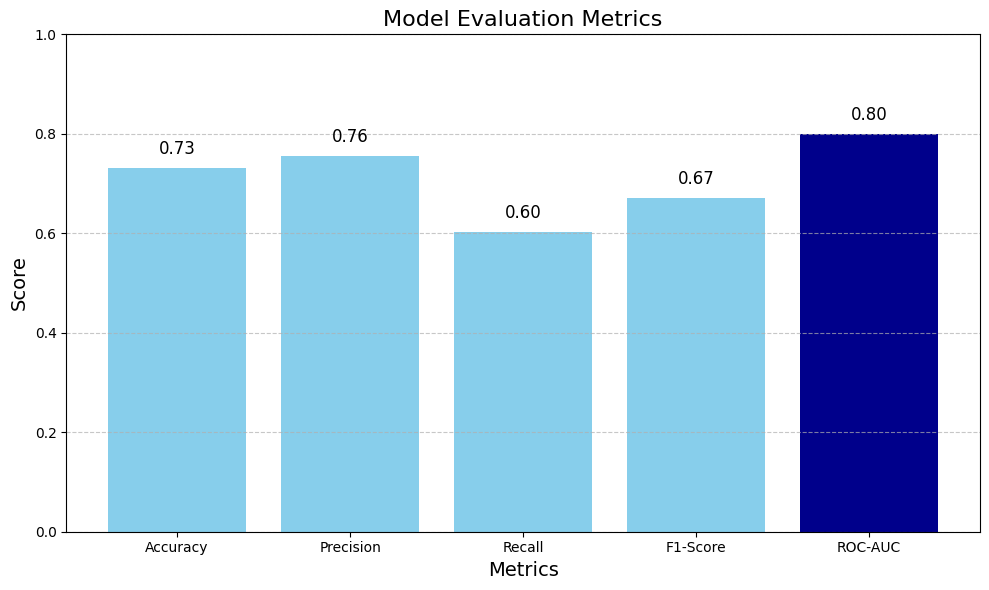

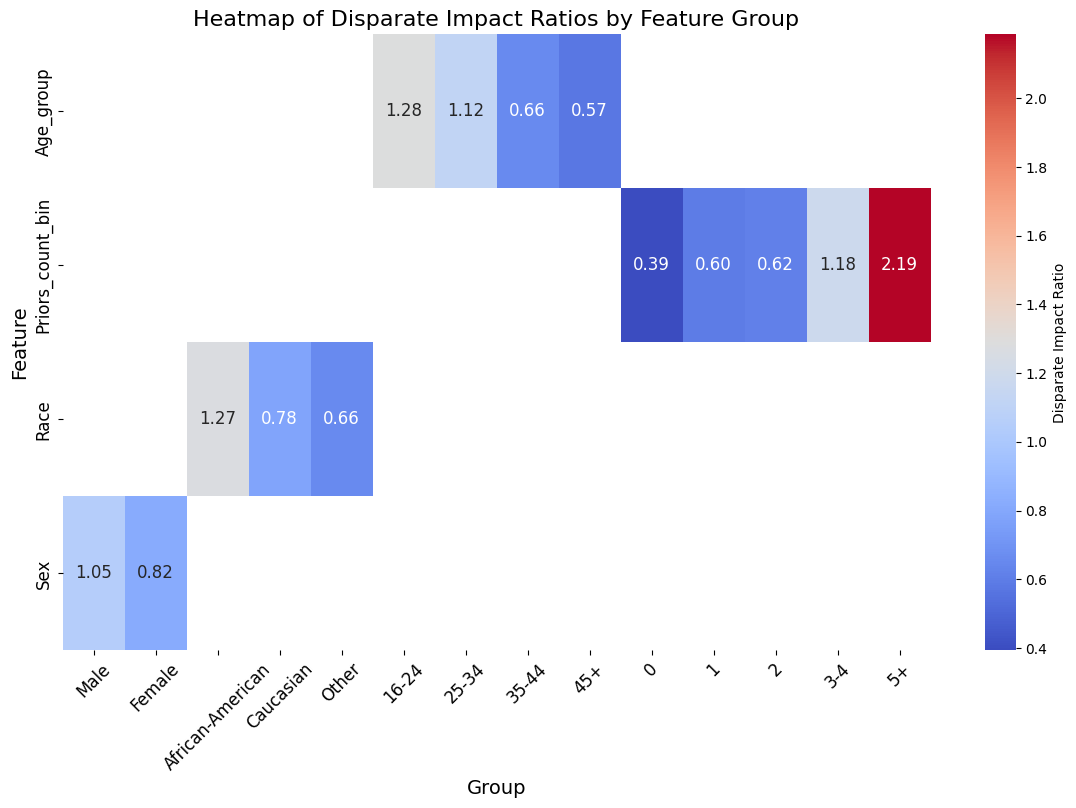

In [205]:
import matplotlib.pyplot as plt


# Define the metrics and their respective scores
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
scores = [accuracy, precision, recall, f1, roc_auc]

# Define colors for each metric
colors = ['skyblue', 'skyblue', 'skyblue', 'skyblue', 'darkblue']  # Dark blue for ROC-AUC

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=colors)
plt.title('Model Evaluation Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on top of each bar with increased font size
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, score + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example function to calculate disparate impact ratios
def calculate_disparate_impact(y_true, y_pred, X_test, column):
    disparate_impact_ratios = {}
    overall_favorable_outcomes = y_pred.mean()
    for value in X_test[column].unique():
        mask = X_test[column] == value
        # Ensure the mask matches the length of y_pred
        if len(mask) != len(y_pred):
            raise ValueError(f"Length mismatch: mask length {len(mask)} does not match y_pred length {len(y_pred)}")
        
        favorable_outcomes = y_pred[mask].mean()
        if overall_favorable_outcomes == 0:
            disparate_impact_ratios[value] = np.nan
        else:
            disparate_impact_ratios[value] = favorable_outcomes / overall_favorable_outcomes
    return disparate_impact_ratios


y_true = y_test

# List of features
features = ['sex', 'race', 'age_group', 'priors_count_bin']

# Calculate disparate impact ratios for each feature and group
disparate_impact_data = {
    'Feature': [],
    'Group': [],
    'Disparate Impact Ratio': []
}

for feature in features:
    disparate_impact_by_group = calculate_disparate_impact(y_true, y_pred, X_test, feature)
    for group, ratio in disparate_impact_by_group.items():
        disparate_impact_data['Feature'].append(feature.capitalize())
        disparate_impact_data['Group'].append(group)
        disparate_impact_data['Disparate Impact Ratio'].append(ratio)

# Convert to DataFrame
disparate_impact_df = pd.DataFrame(disparate_impact_data)

# Pivot table for heatmap
disparate_impact_pivot = disparate_impact_df.pivot(index='Feature', columns='Group', values='Disparate Impact Ratio')

# Reordering columns for consistent plotting
group_order = ['Male', 'Female', 'African-American', 'Caucasian', 'Other', '16-24', '25-34', '35-44', '45+', '0', '1', '2', '3-4', '5+']
disparate_impact_pivot = disparate_impact_pivot[group_order]

# Plotting heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(disparate_impact_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Disparate Impact Ratio'}, annot_kws={'size': 12}, fmt=".2f")
plt.title('Heatmap of Disparate Impact Ratios by Feature Group', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()



### Feature Importance

/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/teresaramoos/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


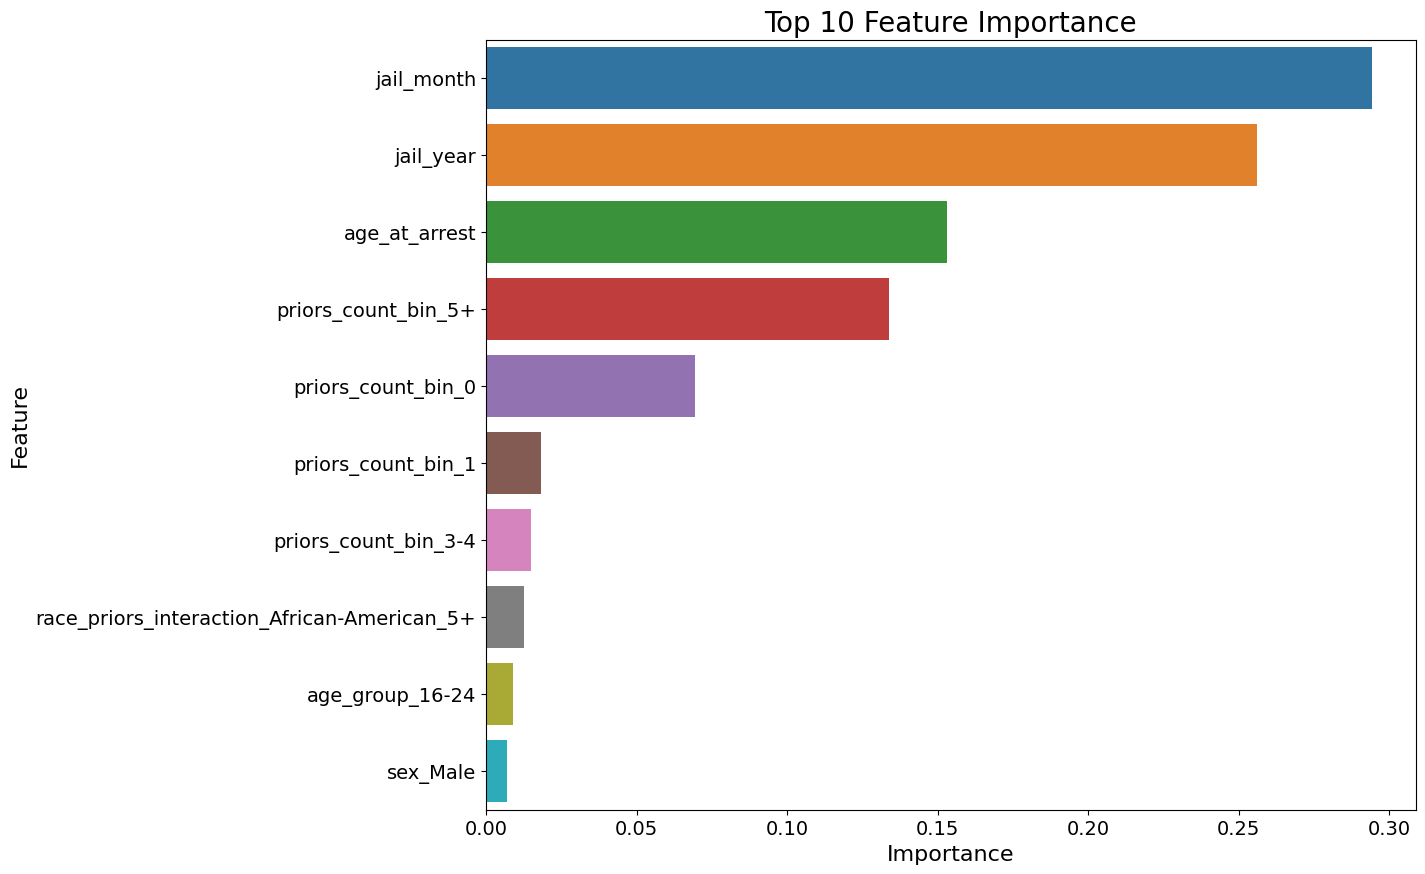

                                        Feature  Importance
5                                    jail_month    0.294066
6                                     jail_year    0.255941
3                                 age_at_arrest    0.153102
22                          priors_count_bin_5+    0.133916
18                           priors_count_bin_0    0.069572
19                           priors_count_bin_1    0.018388
21                         priors_count_bin_3-4    0.014954
27  race_priors_interaction_African-American_5+    0.012647
14                              age_group_16-24    0.008977
8                                      sex_Male    0.006899


In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance
feature_importance = pipeline.named_steps['classifier'].feature_importances_

# Get feature names after one-hot encoding
ohe_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Get top 10 features
top_10_importance_df = importance_df.head(10)

# Plot top 10 feature importance with increased text size
plt.figure(figsize=(12, 10))
sns.barplot(data=top_10_importance_df, x='Importance', y='Feature')
plt.title('Top 10 Feature Importance', fontsize=20)
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Print top 10 features
print(top_10_importance_df)


### Correlation Matrix

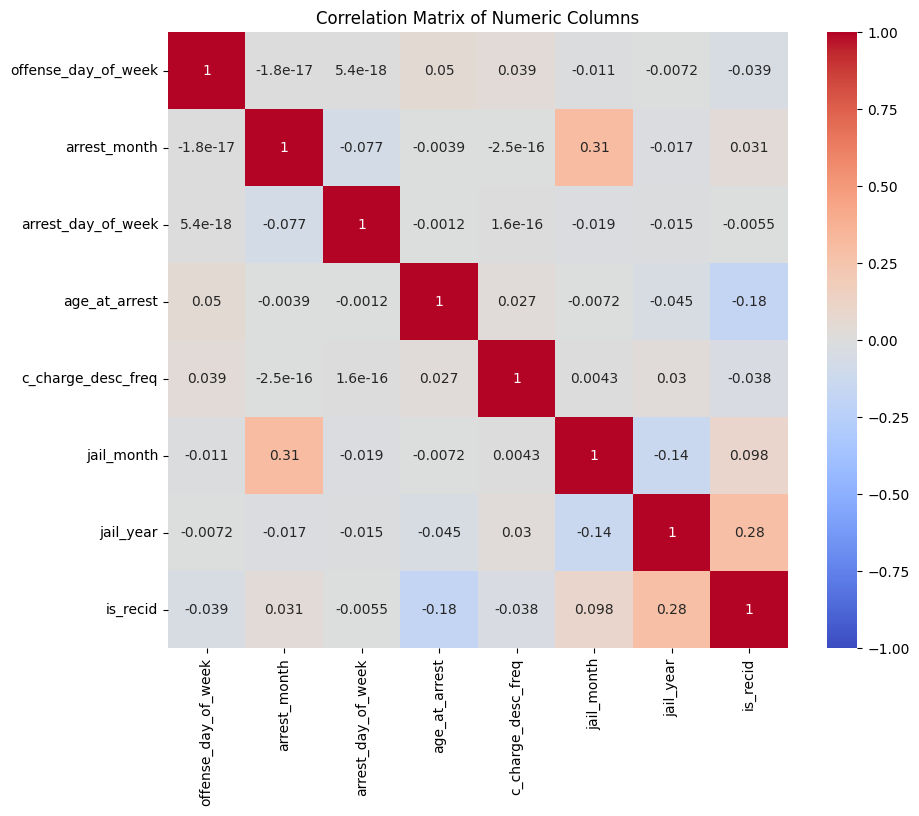

In [318]:
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate correlation matrix for the selected columns
selected_columns = [#"offense_month", 
    "offense_day_of_week", 
    "arrest_month", 
    "arrest_day_of_week",
    "age_at_arrest", 
    "c_charge_desc_freq",
    "jail_month",
    "jail_year",
    'is_recid']

corr_matrix = df[selected_columns].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

### Cross-validation on the training set

Cross-validation AUC scores: [0.78033088 0.8248416  0.81693328 0.80671543 0.81063041]
Mean cross-validation AUC score: 0.8078903183216761
Training Accuracy: 0.75
Training ROC-AUC: 0.82
Test Accuracy: 0.73
Test ROC-AUC: 0.80


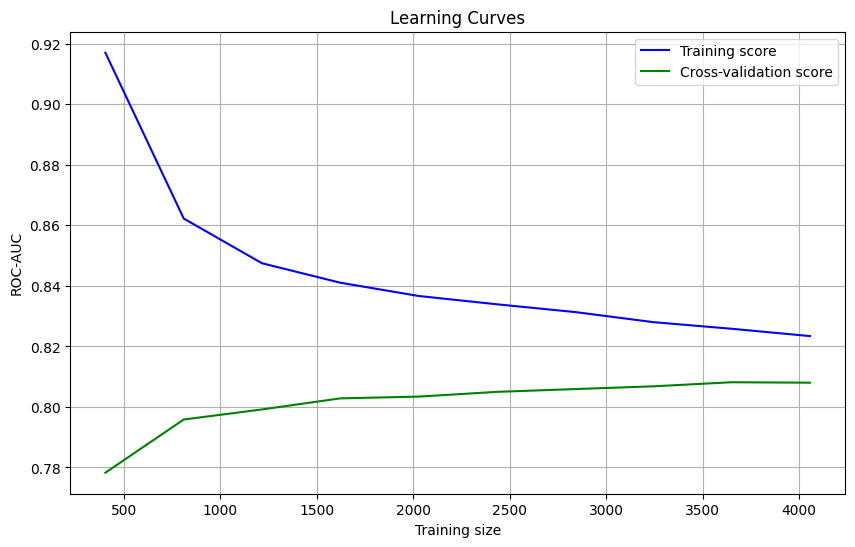

In [320]:
from sklearn.model_selection import cross_val_score

# Cross-validation on the training set
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validation AUC scores:", cv_scores)
print("Mean cross-validation AUC score:", np.mean(cv_scores))

# Evaluate on the training set
y_train_pred = pipeline.predict(X_train)
y_train_proba = pipeline.predict_proba(X_train)[:, 1]
train_accuracy = accuracy_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_proba)

# Evaluate on the test set
y_test_pred = pipeline.predict(X_test)
y_test_proba = pipeline.predict_proba(X_test)[:, 1]
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Training ROC-AUC: {train_roc_auc:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test ROC-AUC: {test_roc_auc:.2f}")

# Plot learning curves
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=5, scoring='roc_auc', train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score', color='blue')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score', color='green')
plt.xlabel('Training size')
plt.ylabel('ROC-AUC')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Model with SMOTE technqiue

In [222]:
from sklearn.model_selection import cross_val_score


# Define the frequency encoding function
def frequency_encoding(df, column):
    freq_encoding = df[column].value_counts(normalize=True)
    df[f'{column}_freq'] = df[column].map(freq_encoding)
    return df

# Define the preprocess_data function
def preprocess_data(df):
    df['dob'] = pd.to_datetime(df['dob'])
    df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])
    df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])
    df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])

    # Create unified_date
    df['unified_date'] = df['c_arrest_date'].combine_first(df['c_offense_date'])

    # Feature engineering
    df['age_jail'] = (df['c_jail_in'] - df['dob']).dt.days // 365
    df['age_arrest'] = (df['unified_date'] - df['dob']).dt.days // 365
    df['total_juv_crimes'] = df['juv_fel_count'] + df['juv_misd_count'] + df['juv_other_count']
    df['total_adult_crimes'] = df['priors_count'] - df['total_juv_crimes']

    # Frequency encoding for 'c_charge_desc'
    df = frequency_encoding(df, 'c_charge_desc')

    # Create age bins
    age_bins = [16, 25, 35, 45, 96]
    age_labels = ['16-24', '25-34', '35-44', '45+']
    df['age_group'] = pd.cut(df['age_jail'], bins=age_bins, labels=age_labels, right=False)

    # Create bins for priors_count
    priors_bins = [0, 1, 2, 3, 5, float('inf')]
    priors_labels = ['0', '1', '2', '3-4', '5+']
    df['priors_count_bin'] = pd.cut(df['priors_count'], bins=priors_bins, labels=priors_labels, right=False)

    # Extract more granular date features
    df['offense_month'] = df['c_offense_date'].dt.month
    df['offense_day_of_week'] = df['c_offense_date'].dt.dayofweek
    df['arrest_month'] = df['c_arrest_date'].dt.month
    df['arrest_day_of_week'] = df['c_arrest_date'].dt.dayofweek

    df['time_to_jail'] = (df['c_jail_in'] - df['c_offense_date']).dt.days
    df['race_priors_interaction'] = df['race'].astype(str) + '_' + df['priors_count_bin'].astype(str)
    df['jail_month'] = df['c_jail_in'].dt.month
    df['jail_year'] = df['c_jail_in'].dt.year


    # Replace specific races with 'Other'
    df['race'] = df['race'].replace({
        'Asian': 'Other',
        'Native American': 'Other',
        'Hispanic': 'Other'
    })

    return df

# Apply preprocessing to the entire dataset
df = preprocess_data(df)

# Split data into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Define features
all_features = [
    "sex", 
    "race", 
    "c_charge_degree", 
    "c_charge_desc_freq",
    "age_arrest", 
    "total_juv_crimes",
    "total_adult_crimes",
    "offense_day_of_week", 
    "arrest_month", 
    "arrest_day_of_week",
    "age_group",
    "priors_count_bin",
    "race_priors_interaction",
    "jail_month",
    "jail_year"
]

numerical_features = [
    "total_juv_crimes",
    "total_adult_crimes",
    "offense_day_of_week", 
    "arrest_month", 
    "arrest_day_of_week",
    "age_arrest", 
    "c_charge_desc_freq",
    "jail_month",
    "jail_year"
]

categorical_features = [
    "sex", 
    "race", 
    "c_charge_degree", 
    "age_group",
    "priors_count_bin",
    "race_priors_interaction"
]

target = 'is_recid'

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Use the best model parameters found earlier
best_model_params = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 0.8,
    'random_state': 42
}

# Create the pipeline with SMOTE
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(**best_model_params))
])

# Train the updated pipeline
X_train = df_train[all_features]
y_train = df_train[target]
pipeline.fit(X_train, y_train)

# Evaluate the updated pipeline on the test set
X_test = df_test[all_features]
y_test = df_test[target]
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Cross-validate the updated pipeline
cv_roc_auc_scores = cross_val_score(pipeline, df[all_features], df[target], cv=5, scoring='roc_auc')
print(f'Cross-Validated ROC-AUC Scores: {cv_roc_auc_scores}')
print(f'Average Cross-Validated ROC-AUC: {cv_roc_auc_scores.mean():.2f}')

#####FAIRNESS#######
# Fairness and Bias Metrics
from fairlearn.metrics import (
    demographic_parity_ratio,
    equalized_odds_ratio,
    true_positive_rate_difference,
    false_positive_rate_difference,
    selection_rate_difference
)
import numpy as np

# Ensure categorical columns are of type str to avoid type issues
X_test['age_group'] = X_test['age_group'].astype(str)
X_test['priors_count_bin'] = X_test['priors_count_bin'].astype(str)

# Fairness metrics
for feature in ['sex', 'race', 'age_group', 'priors_count_bin']:
    print(f"\nFairness metrics for {feature}:")
    disparate_impact = demographic_parity_ratio(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    equalized_odds = equalized_odds_ratio(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    selection_rate_diff = selection_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    print(f"Disparate Impact Ratio: {disparate_impact:.2f}")
    print(f"Equalized Odds Ratio: {equalized_odds:.2f}")
    print(f"True Positive Rate Difference: {tpr_diff:.2f}")
    print(f"False Positive Rate Difference: {fpr_diff:.2f}")
    print(f"Selection Rate Difference: {selection_rate_diff:.2f}")

# Disparate impact ratios by group for each sensitive feature
def calculate_disparate_impact(y_true, y_pred, X_test, column):
    disparate_impact_ratios = {}
    overall_favorable_outcomes = y_pred.mean()
    for value in X_test[column].unique():
        mask = X_test[column] == value
        favorable_outcomes = y_pred[mask].mean()
        if overall_favorable_outcomes == 0:
            disparate_impact_ratios[value] = np.nan
        else:
            disparate_impact_ratios[value] = favorable_outcomes / overall_favorable_outcomes
    return disparate_impact_ratios

for feature in ['sex', 'race', 'age_group', 'priors_count_bin']:
    disparate_impact_by_group = calculate_disparate_impact(y_test, y_pred, X_test, feature)
    print(f"\nDisparate Impact Ratios by {feature.capitalize()}:")
    for group, ratio in disparate_impact_by_group.items():
        print(f"{group}: {ratio:.2f}")


Accuracy: 0.73
Precision: 0.73
Recall: 0.64
F1-Score: 0.68
ROC-AUC: 0.80
Confusion Matrix:
[[556 138]
 [204 370]]
Cross-Validated ROC-AUC Scores: [0.81049793 0.81734054 0.81345269 0.79845915 0.79896358]
Average Cross-Validated ROC-AUC: 0.81

Fairness metrics for sex:
Disparate Impact Ratio: 0.72
Equalized Odds Ratio: 0.42
True Positive Rate Difference: 0.02
False Positive Rate Difference: 0.13
Selection Rate Difference: 0.12

Fairness metrics for race:
Disparate Impact Ratio: 0.49
Equalized Odds Ratio: 0.32
True Positive Rate Difference: 0.20
False Positive Rate Difference: 0.20
Selection Rate Difference: 0.26

Fairness metrics for age_group:
Disparate Impact Ratio: 0.46
Equalized Odds Ratio: 0.24
True Positive Rate Difference: 0.21
False Positive Rate Difference: 0.26
Selection Rate Difference: 0.28

Fairness metrics for priors_count_bin:


/tmp/ipykernel_73/2945828517.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['age_group'] = X_test['age_group'].astype(str)
/tmp/ipykernel_73/2945828517.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['priors_count_bin'] = X_test['priors_count_bin'].astype(str)


Disparate Impact Ratio: 0.18
Equalized Odds Ratio: 0.05
True Positive Rate Difference: 0.50
False Positive Rate Difference: 0.65
Selection Rate Difference: 0.69

Disparate Impact Ratios by Sex:
Male: 1.06
Female: 0.77

Disparate Impact Ratios by Race:
African-American: 1.28
Caucasian: 0.79
Other: 0.63

Disparate Impact Ratios by Age_group:
16-24: 1.31
25-34: 1.08
35-44: 0.64
45+: 0.60

Disparate Impact Ratios by Priors_count_bin:
0: 0.37
1: 0.57
5+: 2.10
3-4: 1.15
2: 0.89


### Metrics plots

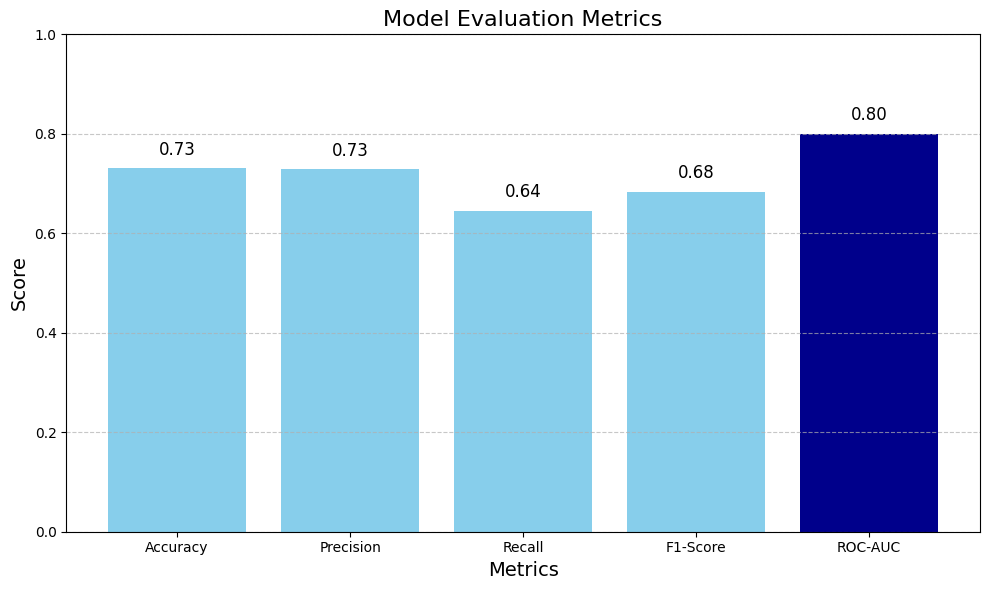

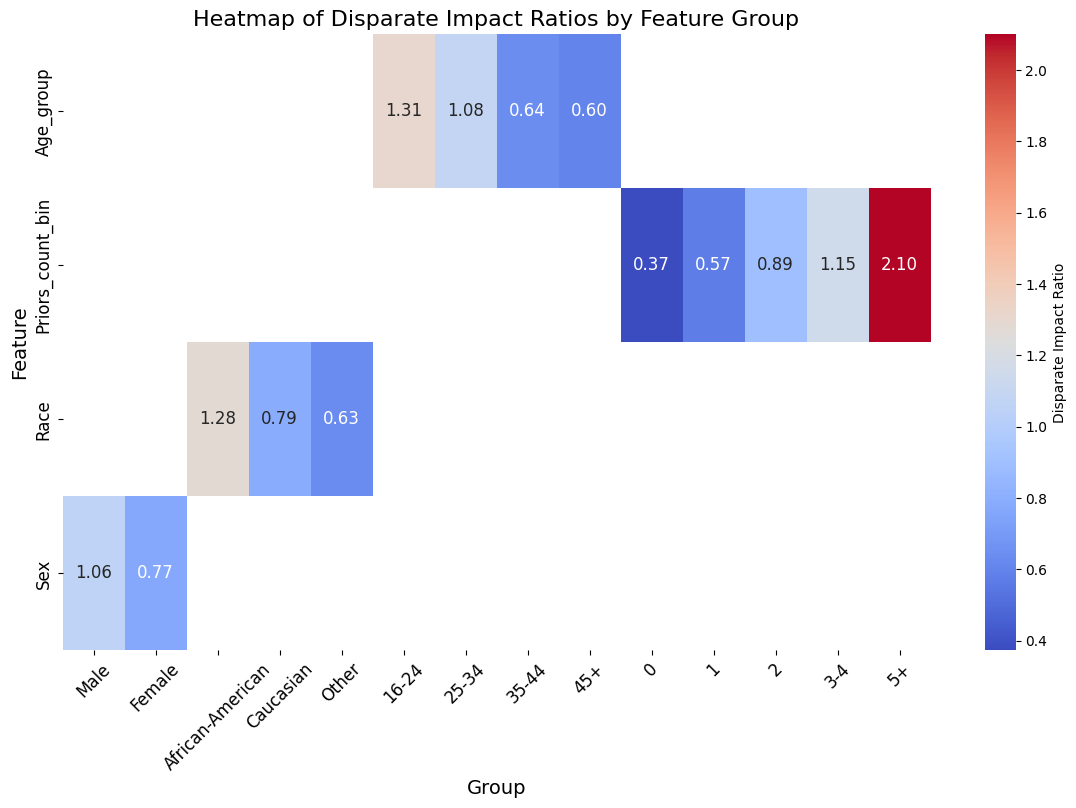

In [223]:
import matplotlib.pyplot as plt


# Define the metrics and their respective scores
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
scores = [accuracy, precision, recall, f1, roc_auc]

# Define colors for each metric
colors = ['skyblue', 'skyblue', 'skyblue', 'skyblue', 'darkblue']  # Dark blue for ROC-AUC

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=colors)
plt.title('Model Evaluation Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on top of each bar with increased font size
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, score + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example function to calculate disparate impact ratios
def calculate_disparate_impact(y_true, y_pred, X_test, column):
    disparate_impact_ratios = {}
    overall_favorable_outcomes = y_pred.mean()
    for value in X_test[column].unique():
        mask = X_test[column] == value
        # Ensure the mask matches the length of y_pred
        if len(mask) != len(y_pred):
            raise ValueError(f"Length mismatch: mask length {len(mask)} does not match y_pred length {len(y_pred)}")
        
        favorable_outcomes = y_pred[mask].mean()
        if overall_favorable_outcomes == 0:
            disparate_impact_ratios[value] = np.nan
        else:
            disparate_impact_ratios[value] = favorable_outcomes / overall_favorable_outcomes
    return disparate_impact_ratios


y_true = y_test

# List of features
features = ['sex', 'race', 'age_group', 'priors_count_bin']

# Calculate disparate impact ratios for each feature and group
disparate_impact_data = {
    'Feature': [],
    'Group': [],
    'Disparate Impact Ratio': []
}

for feature in features:
    disparate_impact_by_group = calculate_disparate_impact(y_true, y_pred, X_test, feature)
    for group, ratio in disparate_impact_by_group.items():
        disparate_impact_data['Feature'].append(feature.capitalize())
        disparate_impact_data['Group'].append(group)
        disparate_impact_data['Disparate Impact Ratio'].append(ratio)

# Convert to DataFrame
disparate_impact_df = pd.DataFrame(disparate_impact_data)

# Pivot table for heatmap
disparate_impact_pivot = disparate_impact_df.pivot(index='Feature', columns='Group', values='Disparate Impact Ratio')

# Reordering columns for consistent plotting
group_order = ['Male', 'Female', 'African-American', 'Caucasian', 'Other', '16-24', '25-34', '35-44', '45+', '0', '1', '2', '3-4', '5+']
disparate_impact_pivot = disparate_impact_pivot[group_order]

# Plotting heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(disparate_impact_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Disparate Impact Ratio'}, annot_kws={'size': 12}, fmt=".2f")
plt.title('Heatmap of Disparate Impact Ratios by Feature Group', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()



## Model with sample weights

In [220]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio, true_positive_rate_difference, false_positive_rate_difference, selection_rate_difference
import pickle

# Define the frequency encoding function
def frequency_encoding(df, column):
    freq_encoding = df[column].value_counts(normalize=True)
    df[f'{column}_freq'] = df[column].map(freq_encoding)
    return df

# Define the preprocess_data function
def preprocess_data(df):
    df['dob'] = pd.to_datetime(df['dob'])
    df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])
    df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])
    df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])

    # Create unified_date
    df['unified_date'] = df['c_arrest_date'].combine_first(df['c_offense_date'])

    # Feature engineering
    df['age_jail'] = (df['c_jail_in'] - df['dob']).dt.days // 365
    df['age_arrest'] = (df['unified_date'] - df['dob']).dt.days // 365
    df['total_juv_crimes'] = df['juv_fel_count'] + df['juv_misd_count'] + df['juv_other_count']
    df['total_adult_crimes'] = df['priors_count'] - df['total_juv_crimes']

    # Frequency encoding for 'c_charge_desc'
    df = frequency_encoding(df, 'c_charge_desc')

    # Create age bins
    age_bins = [16, 25, 35, 45, 96]
    age_labels = ['16-24', '25-34', '35-44', '45+']
    df['age_group'] = pd.cut(df['age_jail'], bins=age_bins, labels=age_labels, right=False)

    # Create bins for priors_count
    priors_bins = [0, 1, 2, 3, 5, float('inf')]
    priors_labels = ['0', '1', '2', '3-4', '5+']
    df['priors_count_bin'] = pd.cut(df['priors_count'], bins=priors_bins, labels=priors_labels, right=False)

    # Extract more granular date features
    df['offense_month'] = df['c_offense_date'].dt.month
    df['offense_day_of_week'] = df['c_offense_date'].dt.dayofweek
    df['arrest_month'] = df['c_arrest_date'].dt.month
    df['arrest_day_of_week'] = df['c_arrest_date'].dt.dayofweek

    df['time_to_jail'] = (df['c_jail_in'] - df['c_offense_date']).dt.days
    df['race_priors_interaction'] = df['race'].astype(str) + '_' + df['priors_count_bin'].astype(str)
    df['jail_month'] = df['c_jail_in'].dt.month
    df['jail_year'] = df['c_jail_in'].dt.year


    # Replace specific races with 'Other'
    df['race'] = df['race'].replace({
        'Asian': 'Other',
        'Native American': 'Other',
        'Hispanic': 'Other'
    })

    return df

# Apply preprocessing to the entire dataset
df = preprocess_data(df)

# Split data into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Define features
all_features = [
    "sex", 
    "race", 
    "c_charge_degree", 
    "c_charge_desc_freq",
    "age_arrest", 
    "total_juv_crimes",
    "total_adult_crimes",
    "offense_day_of_week", 
    "arrest_month", 
    "arrest_day_of_week",
    "age_group",
    "priors_count_bin",
    "race_priors_interaction",
    "jail_month",
    "jail_year"
]

numerical_features = [
    "total_juv_crimes",
    "total_adult_crimes",
    "offense_day_of_week", 
    "arrest_month", 
    "arrest_day_of_week",
    "age_arrest", 
    "c_charge_desc_freq",
    "jail_month",
    "jail_year"
]

categorical_features = [
    "sex", 
    "race", 
    "c_charge_degree", 
    "age_group",
    "priors_count_bin",
    "race_priors_interaction"
]

target = 'is_recid'

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Calculate weights based on the race and sex attributes
def calculate_sample_weights(df, protected_attributes):
    sample_weights = pd.Series([1.0] * len(df))
    for attr in protected_attributes:
        value_counts = df[attr].value_counts(normalize=True)
        attr_weights = df[attr].apply(lambda x: 1 / value_counts[x])
        sample_weights *= attr_weights
    return sample_weights

# Get sample weights for training data
sample_weights = calculate_sample_weights(df_train, ['race', 'sex'])

# Ensure there are no NaN values in sample_weights
sample_weights = sample_weights.fillna(1.0)

# Update the pipeline with the best model and parameters
best_model_params = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample':0.8,
    'random_state': 42
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(**best_model_params))
])

X_train = df_train[all_features]
y_train = df_train[target]
pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)

# Evaluate the model on the test set
X_test = df_test[all_features]
y_test = df_test[target]
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')
print(f'Confusion Matrix:\n{conf_matrix}')

#####FAIRNESS#######
# Ensure categorical columns are of type str to avoid type issues
X_test['age_group'] = X_test['age_group'].astype(str)
X_test['priors_count_bin'] = X_test['priors_count_bin'].astype(str)

# Fairness metrics
for feature in ['sex', 'race', 'age_group', 'priors_count_bin']:
    print(f"\nFairness metrics for {feature}:")
    disparate_impact = demographic_parity_ratio(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    equalized_odds = equalized_odds_ratio(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    selection_rate_diff = selection_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=X_test[feature])
    print(f"Disparate Impact Ratio: {disparate_impact:.2f}")
    print(f"Equalized Odds Ratio: {equalized_odds:.2f}")
    print(f"True Positive Rate Difference: {tpr_diff:.2f}")
    print(f"False Positive Rate Difference: {fpr_diff:.2f}")
    print(f"Selection Rate Difference: {selection_rate_diff:.2f}")

# Disparate impact ratios by group for each sensitive feature
def calculate_disparate_impact(y_true, y_pred, X_test, column):
    disparate_impact_ratios = {}
    overall_favorable_outcomes = y_pred.mean()
    for value in X_test[column].unique():
        mask = X_test[column] == value
        favorable_outcomes = y_pred[mask].mean()
        if overall_favorable_outcomes == 0:
            disparate_impact_ratios[value] = np.nan
        else:
            disparate_impact_ratios[value] = favorable_outcomes / overall_favorable_outcomes
    return disparate_impact_ratios

for feature in ['sex', 'race', 'age_group', 'priors_count_bin']:
    disparate_impact_by_group = calculate_disparate_impact(y_test, y_pred, X_test, feature)
    print(f"\nDisparate Impact Ratios by {feature.capitalize()}:")
    for group, ratio in disparate_impact_by_group.items():
        print(f"{group}: {ratio:.2f}")


Accuracy: 0.73
Precision: 0.77
Recall: 0.57
F1-Score: 0.65
ROC-AUC: 0.79
Confusion Matrix:
[[595  99]
 [248 326]]

Fairness metrics for sex:
Disparate Impact Ratio: 0.72
Equalized Odds Ratio: 0.43
True Positive Rate Difference: 0.03
False Positive Rate Difference: 0.09
Selection Rate Difference: 0.10

Fairness metrics for race:
Disparate Impact Ratio: 0.48
Equalized Odds Ratio: 0.29
True Positive Rate Difference: 0.18
False Positive Rate Difference: 0.15
Selection Rate Difference: 0.23

Fairness metrics for age_group:
Disparate Impact Ratio: 0.38
Equalized Odds Ratio: 0.13
True Positive Rate Difference: 0.19
False Positive Rate Difference: 0.23
Selection Rate Difference: 0.28

Fairness metrics for priors_count_bin:


/tmp/ipykernel_73/80125447.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['age_group'] = X_test['age_group'].astype(str)
/tmp/ipykernel_73/80125447.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['priors_count_bin'] = X_test['priors_count_bin'].astype(str)


Disparate Impact Ratio: 0.19
Equalized Odds Ratio: 0.05
True Positive Rate Difference: 0.42
False Positive Rate Difference: 0.53
Selection Rate Difference: 0.59

Disparate Impact Ratios by Sex:
Male: 1.06
Female: 0.77

Disparate Impact Ratios by Race:
African-American: 1.29
Caucasian: 0.77
Other: 0.62

Disparate Impact Ratios by Age_group:
16-24: 1.33
25-34: 1.09
35-44: 0.68
45+: 0.51

Disparate Impact Ratios by Priors_count_bin:
0: 0.42
1: 0.64
5+: 2.19
3-4: 1.02
2: 0.66


### Metrics plots

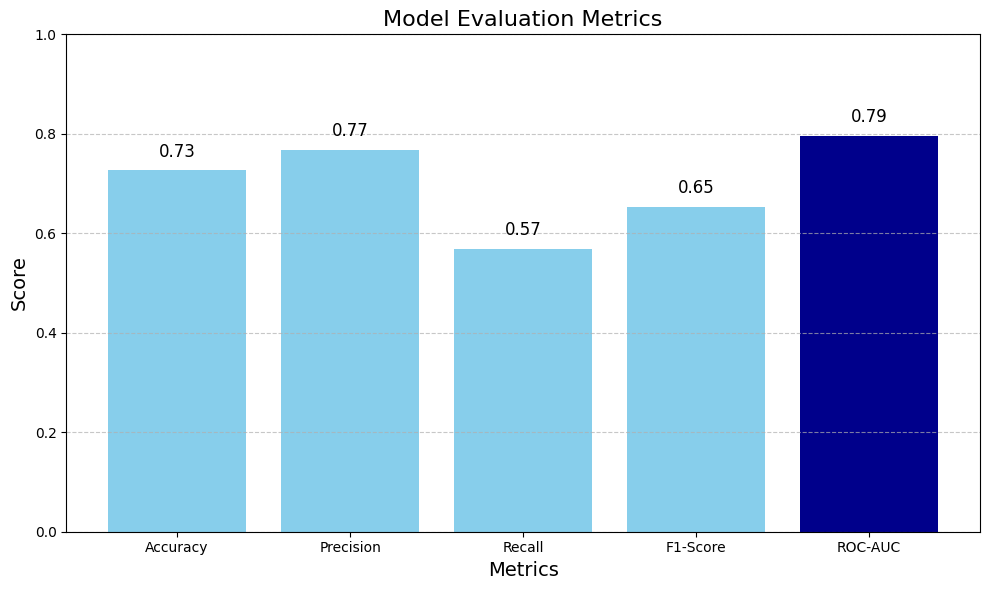

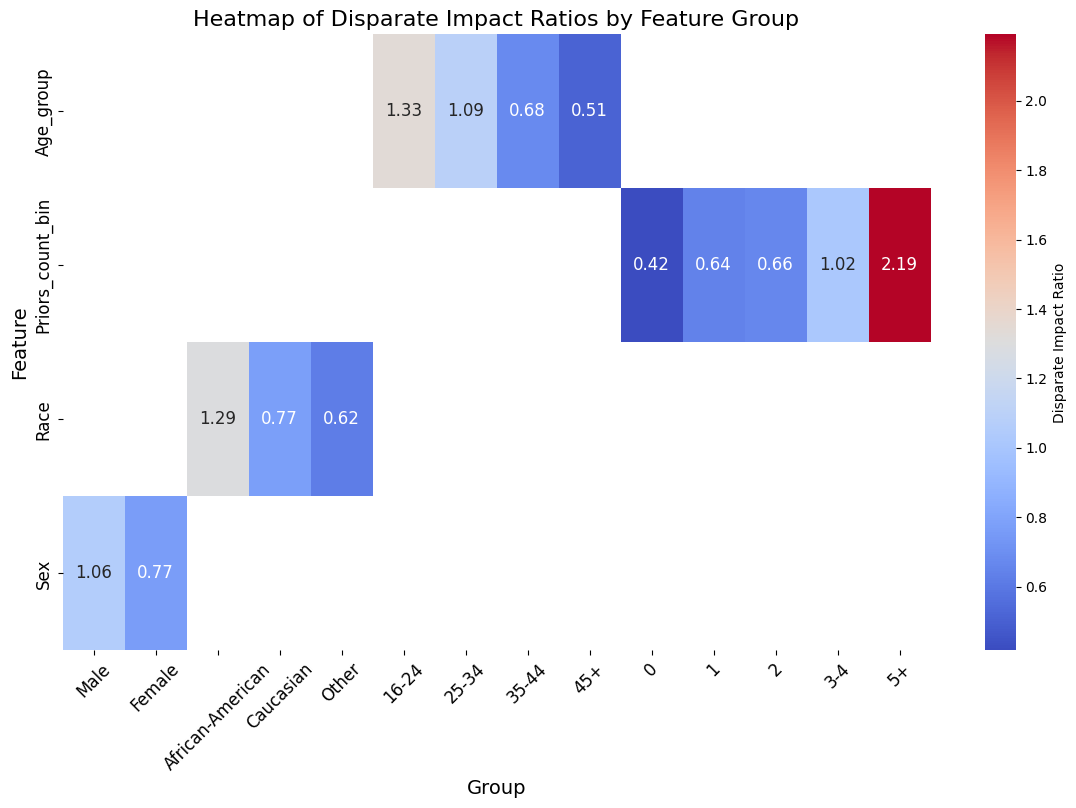

In [221]:
import matplotlib.pyplot as plt


# Define the metrics and their respective scores
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
scores = [accuracy, precision, recall, f1, roc_auc]

# Define colors for each metric
colors = ['skyblue', 'skyblue', 'skyblue', 'skyblue', 'darkblue']  # Dark blue for ROC-AUC

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=colors)
plt.title('Model Evaluation Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on top of each bar with increased font size
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, score + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example function to calculate disparate impact ratios
def calculate_disparate_impact(y_true, y_pred, X_test, column):
    disparate_impact_ratios = {}
    overall_favorable_outcomes = y_pred.mean()
    for value in X_test[column].unique():
        mask = X_test[column] == value
        # Ensure the mask matches the length of y_pred
        if len(mask) != len(y_pred):
            raise ValueError(f"Length mismatch: mask length {len(mask)} does not match y_pred length {len(y_pred)}")
        
        favorable_outcomes = y_pred[mask].mean()
        if overall_favorable_outcomes == 0:
            disparate_impact_ratios[value] = np.nan
        else:
            disparate_impact_ratios[value] = favorable_outcomes / overall_favorable_outcomes
    return disparate_impact_ratios


y_true = y_test

# List of features
features = ['sex', 'race', 'age_group', 'priors_count_bin']

# Calculate disparate impact ratios for each feature and group
disparate_impact_data = {
    'Feature': [],
    'Group': [],
    'Disparate Impact Ratio': []
}

for feature in features:
    disparate_impact_by_group = calculate_disparate_impact(y_true, y_pred, X_test, feature)
    for group, ratio in disparate_impact_by_group.items():
        disparate_impact_data['Feature'].append(feature.capitalize())
        disparate_impact_data['Group'].append(group)
        disparate_impact_data['Disparate Impact Ratio'].append(ratio)

# Convert to DataFrame
disparate_impact_df = pd.DataFrame(disparate_impact_data)

# Pivot table for heatmap
disparate_impact_pivot = disparate_impact_df.pivot(index='Feature', columns='Group', values='Disparate Impact Ratio')

# Reordering columns for consistent plotting
group_order = ['Male', 'Female', 'African-American', 'Caucasian', 'Other', '16-24', '25-34', '35-44', '45+', '0', '1', '2', '3-4', '5+']
disparate_impact_pivot = disparate_impact_pivot[group_order]

# Plotting heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(disparate_impact_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Disparate Impact Ratio'}, annot_kws={'size': 12}, fmt=".2f")
plt.title('Heatmap of Disparate Impact Ratios by Feature Group', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()



## Model with DemographicParity constraint for ex, race, age and prior crimes

In [218]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio, true_positive_rate_difference, false_positive_rate_difference, selection_rate_difference
import pickle

# Define the frequency encoding function
def frequency_encoding(df, column):
    freq_encoding = df[column].value_counts(normalize=True)
    df[f'{column}_freq'] = df[column].map(freq_encoding)
    return df

# Define the preprocess_data function
def preprocess_data(df):
    df['dob'] = pd.to_datetime(df['dob'])
    df['c_offense_date'] = pd.to_datetime(df['c_offense_date'])
    df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'])
    df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])

    # Create unified_date
    df['unified_date'] = df['c_arrest_date'].combine_first(df['c_offense_date'])

    # Feature engineering
    df['age_jail'] = (df['c_jail_in'] - df['dob']).dt.days // 365
    df['age_arrest'] = (df['unified_date'] - df['dob']).dt.days // 365
    df['total_juv_crimes'] = df['juv_fel_count'] + df['juv_misd_count'] + df['juv_other_count']
    df['total_adult_crimes'] = df['priors_count'] - df['total_juv_crimes']

    # Frequency encoding for 'c_charge_desc'
    df = frequency_encoding(df, 'c_charge_desc')

    # Create age bins
    age_bins = [16, 25, 35, 45, 96]
    age_labels = ['16-24', '25-34', '35-44', '45+']
    df['age_group'] = pd.cut(df['age_jail'], bins=age_bins, labels=age_labels, right=False)

    # Create bins for priors_count
    priors_bins = [0, 1, 2, 3, 5, float('inf')]
    priors_labels = ['0', '1', '2', '3-4', '5+']
    df['priors_count_bin'] = pd.cut(df['priors_count'], bins=priors_bins, labels=priors_labels, right=False)

    # Extract more granular date features
    df['offense_month'] = df['c_offense_date'].dt.month
    df['offense_day_of_week'] = df['c_offense_date'].dt.dayofweek
    df['arrest_month'] = df['c_arrest_date'].dt.month
    df['arrest_day_of_week'] = df['c_arrest_date'].dt.dayofweek

    df['time_to_jail'] = (df['c_jail_in'] - df['c_offense_date']).dt.days
    df['race_priors_interaction'] = df['race'].astype(str) + '_' + df['priors_count_bin'].astype(str)
    df['jail_month'] = df['c_jail_in'].dt.month
    df['jail_year'] = df['c_jail_in'].dt.year


    # Replace specific races with 'Other'
    df['race'] = df['race'].replace({
        'Asian': 'Other',
        'Native American': 'Other',
        'Hispanic': 'Other'
    })

    return df

# Apply preprocessing to the entire dataset
df = preprocess_data(df)

# Split data into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Define features
all_features = [
    "sex", 
    "race", 
    "c_charge_degree", 
    "c_charge_desc_freq",
    "age_arrest", 
    "total_juv_crimes",
    "total_adult_crimes",
    "offense_day_of_week", 
    "arrest_month", 
    "arrest_day_of_week",
    "age_group",
    "priors_count_bin",
    "race_priors_interaction",
    "jail_month",
    "jail_year"
]

numerical_features = [
    "total_juv_crimes",
    "total_adult_crimes",
    "offense_day_of_week", 
    "arrest_month", 
    "arrest_day_of_week",
    "age_arrest", 
    "c_charge_desc_freq",
    "jail_month",
    "jail_year"
]

categorical_features = [
    "sex", 
    "race", 
    "c_charge_degree", 
    "age_group",
    "priors_count_bin",
    "race_priors_interaction"
]

target = 'is_recid'

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply fairness constraints
constraint = DemographicParity()
mitigator = ExponentiatedGradient(
    estimator=GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8, random_state=42),
    constraints=constraint
)

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mitigator', mitigator)
])

# Encode sensitive features
X_train = df_train[all_features]
y_train = df_train[target]

X_test = df_test[all_features]
y_test = df_test[target]

sensitive_features_train = df_train[['sex', 'race', 'age_group', 'priors_count_bin']]
sensitive_features_test = df_test[['sex', 'race', 'age_group', 'priors_count_bin']]

# Fit the pipeline
pipeline.fit(X_train, y_train, mitigator__sensitive_features=sensitive_features_train)

# Evaluate the model with fairness constraints on the test set
y_pred_fair = pipeline.predict(X_test)

# Evaluate model performance
accuracy_fair = accuracy_score(y_test, y_pred_fair)
precision_fair = precision_score(y_test, y_pred_fair)
recall_fair = recall_score(y_test, y_pred_fair)
f1_fair = f1_score(y_test, y_pred_fair)
roc_auc_fair = roc_auc_score(y_test, y_pred_fair)
conf_matrix_fair = confusion_matrix(y_test, y_pred_fair)

print(f"Accuracy: {accuracy_fair:.2f}")
print(f"Precision: {precision_fair:.2f}")
print(f"Recall: {recall_fair:.2f}")
print(f"F1-Score: {f1_fair:.2f}")
print(f"ROC-AUC: {roc_auc_fair:.2f}")
print(f"Confusion Matrix:\n{conf_matrix_fair}")

# Fairness metrics
for feature in ['sex', 'race', 'age_group', 'priors_count_bin']:
    print(f"\nFairness metrics for {feature}:")
    disparate_impact = demographic_parity_ratio(y_true=y_test, y_pred=y_pred_fair, sensitive_features=X_test[feature])
    equalized_odds = equalized_odds_ratio(y_true=y_test, y_pred=y_pred_fair, sensitive_features=X_test[feature])
    tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred_fair, sensitive_features=X_test[feature])
    fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred_fair, sensitive_features=X_test[feature])
    selection_rate_diff = selection_rate_difference(y_true=y_test, y_pred=y_pred_fair, sensitive_features=X_test[feature])
    print(f"Disparate Impact Ratio: {disparate_impact:.2f}")
    print(f"Equalized Odds Ratio: {equalized_odds:.2f}")
    print(f"True Positive Rate Difference: {tpr_diff:.2f}")
    print(f"False Positive Rate Difference: {fpr_diff:.2f}")
    print(f"Selection Rate Difference: {selection_rate_diff:.2f}")

# Disparate impact ratios by group for each sensitive feature
def calculate_disparate_impact(y_true, y_pred, X_test, column):
    disparate_impact_ratios = {}
    overall_favorable_outcomes = y_pred.mean()
    for value in X_test[column].unique():
        mask = X_test[column] == value
        favorable_outcomes = y_pred[mask].mean()
        if overall_favorable_outcomes == 0:
            disparate_impact_ratios[value] = np.nan
        else:
            disparate_impact_ratios[value] = favorable_outcomes / overall_favorable_outcomes
    return disparate_impact_ratios

for feature in ['sex', 'race', 'age_group', 'priors_count_bin']:
    disparate_impact_by_group = calculate_disparate_impact(y_test, y_pred_fair, X_test, feature)
    print(f"\nDisparate Impact Ratios by {feature.capitalize()}:")
    for group, ratio in disparate_impact_by_group.items():
        print(f"{group}: {ratio:.2f}")



/home/teresaramoos/.local/lib/python3.10/site-packages/fairlearn/reductions/_exponentiated_gradient/_lagrangian.py:264: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas[h_idx] = h_gamma
/home/teresaramoos/.local/lib/python3.10/site-packages/fairlearn/reductions/_exponentiated_gradient/_lagrangian.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambdas[h_idx] = lambda_vec.copy()
/home/teresaramoos/.local/lib/python3.10/site-packages/fairlearn/reductions/_exponentiated_gradient/exponentiated_gradient.py:346: Pe

Accuracy: 0.58
Precision: 0.54
Recall: 0.45
F1-Score: 0.49
ROC-AUC: 0.57
Confusion Matrix:
[[472 222]
 [313 261]]

Fairness metrics for sex:
Disparate Impact Ratio: 0.96
Equalized Odds Ratio: 0.78
True Positive Rate Difference: 0.06
False Positive Rate Difference: 0.09
Selection Rate Difference: 0.02

Fairness metrics for race:
Disparate Impact Ratio: 0.86
Equalized Odds Ratio: 0.70
True Positive Rate Difference: 0.03
False Positive Rate Difference: 0.12
Selection Rate Difference: 0.06

Fairness metrics for age_group:
Disparate Impact Ratio: 0.84
Equalized Odds Ratio: 0.74
True Positive Rate Difference: 0.13
False Positive Rate Difference: 0.05
Selection Rate Difference: 0.07

Fairness metrics for priors_count_bin:
Disparate Impact Ratio: 0.81
Equalized Odds Ratio: 0.78
True Positive Rate Difference: 0.11
False Positive Rate Difference: 0.05
Selection Rate Difference: 0.08

Disparate Impact Ratios by Sex:
Male: 0.99
Female: 1.03

Disparate Impact Ratios by Race:
African-American: 1.04


### Metrics visualizations

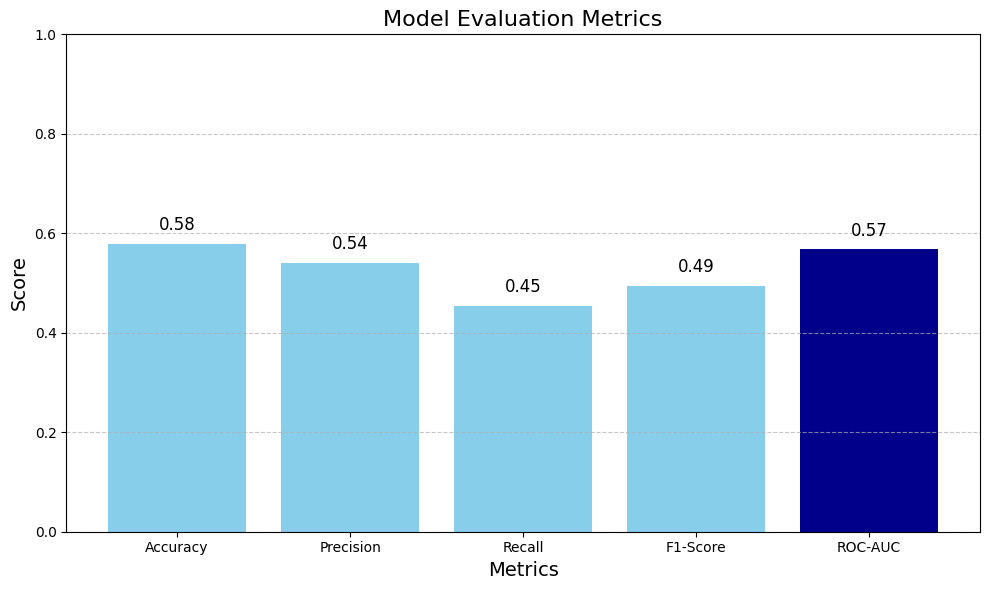

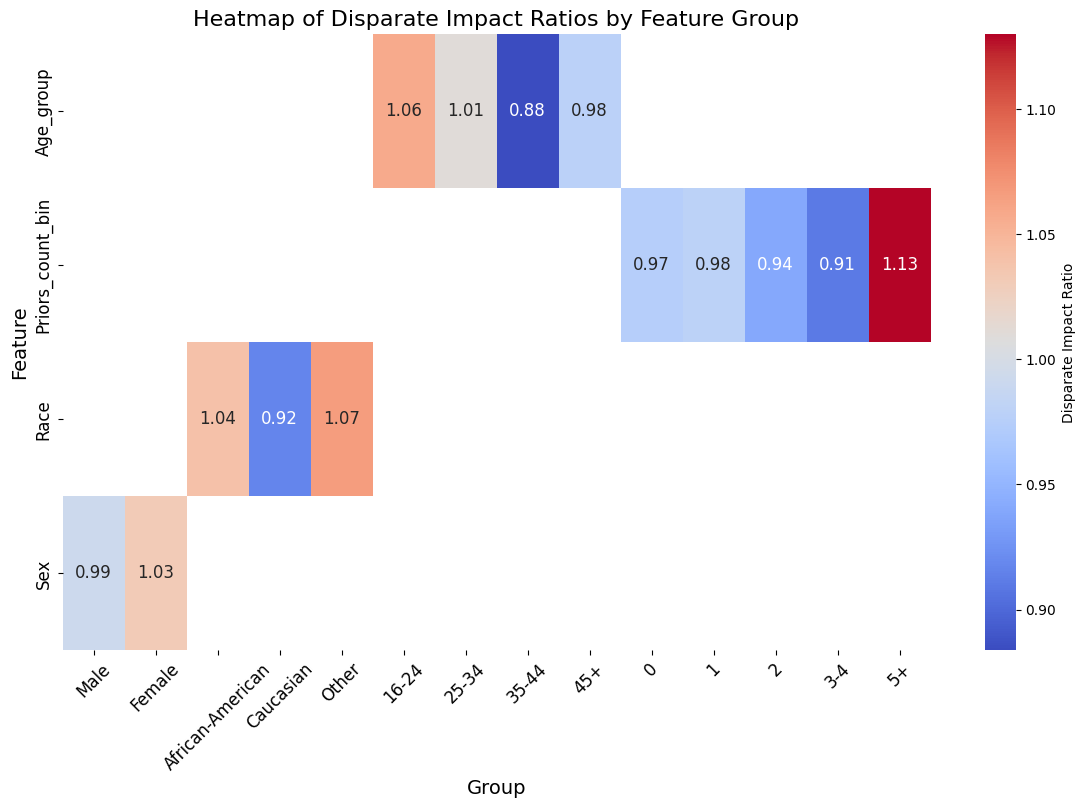

In [219]:
import matplotlib.pyplot as plt


# Define the metrics and their respective scores
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
scores = [accuracy_fair, precision_fair, recall_fair, f1_fair, roc_auc_fair]

# Define colors for each metric
colors = ['skyblue', 'skyblue', 'skyblue', 'skyblue', 'darkblue']  # Dark blue for ROC-AUC

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=colors)
plt.title('Model Evaluation Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on top of each bar with increased font size
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, score + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example function to calculate disparate impact ratios
def calculate_disparate_impact(y_true, y_pred, X_test, column):
    disparate_impact_ratios = {}
    overall_favorable_outcomes = y_pred.mean()
    for value in X_test[column].unique():
        mask = X_test[column] == value
        # Ensure the mask matches the length of y_pred
        if len(mask) != len(y_pred):
            raise ValueError(f"Length mismatch: mask length {len(mask)} does not match y_pred length {len(y_pred)}")
        
        favorable_outcomes = y_pred[mask].mean()
        if overall_favorable_outcomes == 0:
            disparate_impact_ratios[value] = np.nan
        else:
            disparate_impact_ratios[value] = favorable_outcomes / overall_favorable_outcomes
    return disparate_impact_ratios


y_true = y_test

# List of features
features = ['sex', 'race', 'age_group', 'priors_count_bin']

# Calculate disparate impact ratios for each feature and group
disparate_impact_data = {
    'Feature': [],
    'Group': [],
    'Disparate Impact Ratio': []
}

for feature in features:
    disparate_impact_by_group = calculate_disparate_impact(y_true, y_pred_fair, X_test, feature)
    for group, ratio in disparate_impact_by_group.items():
        disparate_impact_data['Feature'].append(feature.capitalize())
        disparate_impact_data['Group'].append(group)
        disparate_impact_data['Disparate Impact Ratio'].append(ratio)

# Convert to DataFrame
disparate_impact_df = pd.DataFrame(disparate_impact_data)

# Pivot table for heatmap
disparate_impact_pivot = disparate_impact_df.pivot(index='Feature', columns='Group', values='Disparate Impact Ratio')

# Reordering columns for consistent plotting
group_order = ['Male', 'Female', 'African-American', 'Caucasian', 'Other', '16-24', '25-34', '35-44', '45+', '0', '1', '2', '3-4', '5+']
disparate_impact_pivot = disparate_impact_pivot[group_order]

# Plotting heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(disparate_impact_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Disparate Impact Ratio'}, annot_kws={'size': 12}, fmt=".2f")
plt.title('Heatmap of Disparate Impact Ratios by Feature Group', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()



## Model with DemographicParity constraint for sex, race and age (and Final)

In [4]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio, true_positive_rate_difference, false_positive_rate_difference, selection_rate_difference
import pickle

# Define the frequency encoding function
def frequency_encoding(df, column):
    freq_encoding = df[column].value_counts(normalize=True)
    df[f'{column}_freq'] = df[column].map(freq_encoding)
    return df

# Define the preprocess_data function
def preprocess_data(df):
    
    df = df.copy()
    
    df = df.dropna(subset=['c_jail_in'])
    df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
    df['c_offense_date'] = pd.to_datetime(df['c_offense_date'], errors='coerce')
    df['c_arrest_date'] = pd.to_datetime(df['c_arrest_date'], errors='coerce')
    df['c_jail_in'] = pd.to_datetime(df['c_jail_in'], errors='coerce')
    df['unified_date'] = df['c_arrest_date'].combine_first(df['c_offense_date'])
    df['age_jail'] = (df['c_jail_in'] - df['dob']).dt.days // 365 if df['c_jail_in'].notnull().all() else None
    df['age_arrest'] = (df['unified_date'] - df['dob']).dt.days // 365 if df['unified_date'].notnull().all() else None
    df['total_juv_crimes'] = df['juv_fel_count'] + df['juv_misd_count'] + df['juv_other_count']
    df['total_adult_crimes'] = df['priors_count'] - df['total_juv_crimes'] if df['priors_count'].notnull().all() else None
    df = frequency_encoding(df, 'c_charge_desc')
    
    # Handling age_group None values
    df['age_jail'] = df['age_jail'].fillna(-1)
    age_bins = [16, 25, 35, 45, 96]
    age_labels = ['16-24', '25-34', '35-44', '45+']
    df['age_group'] = pd.cut(df['age_jail'], bins=age_bins, labels=age_labels, right=False)
    df['age_jail'] = df['age_jail'].replace(-1, None)

    priors_bins = [0, 1, 2, 3, 5, float('inf')]
    priors_labels = ['0', '1', '2', '3-4', '5+']
    df['priors_count'] = df['priors_count'].fillna(-1)  # Fill None values with -1 before binning
    df['priors_count_bin'] = pd.cut(df['priors_count'], bins=priors_bins, labels=priors_labels, right=False)
    df['priors_count'] = df['priors_count'].replace(-1, None)  # Restore None values

    df['offense_month'] = df['c_offense_date'].dt.month
    df['offense_day_of_week'] = df['c_offense_date'].dt.dayofweek
    df['arrest_month'] = df['c_arrest_date'].dt.month
    df['arrest_day_of_week'] = df['c_arrest_date'].dt.dayofweek
    df['time_to_jail'] = (df['c_jail_in'] - df['c_offense_date']).dt.days if df['c_jail_in'].notnull().all() and df['c_offense_date'].notnull().all() else None
    df['race_priors_interaction'] = df['race'].astype(str) + '_' + df['priors_count_bin'].astype(str)
    df['jail_month'] = df['c_jail_in'].dt.month if df['c_jail_in'].notnull().all() else None
    df['jail_year'] = df['c_jail_in'].dt.year if df['c_jail_in'].notnull().all() else None
    df['race'] = df['race'].replace({'Asian': 'Other', 'Native American': 'Other', 'Hispanic': 'Other'})
    return df


# Apply preprocessing to the entire dataset
df = preprocess_data(df)

# Split data into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Define features
all_features = [
    "sex", 
    "race", 
    "c_charge_degree", 
    "c_charge_desc_freq",
    "age_arrest", 
    "total_juv_crimes",
    "total_adult_crimes",
    "offense_day_of_week", 
    "arrest_month", 
    "arrest_day_of_week",
    "age_group",
    "priors_count_bin",
    "race_priors_interaction",
    "jail_month",
    "jail_year"
]

numerical_features = [
    "total_juv_crimes",
    "total_adult_crimes",
    "offense_day_of_week", 
    "arrest_month", 
    "arrest_day_of_week",
    "age_arrest", 
    "c_charge_desc_freq",
    "jail_month",
    "jail_year"
]

categorical_features = [
    "sex", 
    "race", 
    "c_charge_degree", 
    "age_group",
    "priors_count_bin",
    "race_priors_interaction"
]

target = 'is_recid'

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Set sparse_output to False
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply fairness constraints
constraint = DemographicParity()
mitigator = ExponentiatedGradient(
    estimator=GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8, random_state=42),
    constraints=constraint
)

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mitigator', mitigator)
])

# Encode sensitive features
X_train = df_train[all_features].copy()
y_train = df_train[target]

X_test = df_test[all_features].copy()
y_test = df_test[target]

sensitive_features_train = df_train[['sex', 'race', 'age_group']].copy()
sensitive_features_test = df_test[['sex', 'race', 'age_group']].copy()

# Ensure no NaN values in sensitive features
sensitive_features_train = sensitive_features_train.dropna()
sensitive_features_test = sensitive_features_test.dropna()

# Fit the pipeline
pipeline.fit(X_train, y_train, mitigator__sensitive_features=sensitive_features_train)

# Evaluate the model with fairness constraints on the test set
y_pred_fair = pipeline.predict(X_test)

# Evaluate model performance
accuracy_fair = accuracy_score(y_test, y_pred_fair)
precision_fair = precision_score(y_test, y_pred_fair)
recall_fair = recall_score(y_test, y_pred_fair)
f1_fair = f1_score(y_test, y_pred_fair)
roc_auc_fair = roc_auc_score(y_test, y_pred_fair)
conf_matrix_fair = confusion_matrix(y_test, y_pred_fair)

print(f"Accuracy: {accuracy_fair:.2f}")
print(f"Precision: {precision_fair:.2f}")
print(f"Recall: {recall_fair:.2f}")
print(f"F1-Score: {f1_fair:.2f}")
print(f"ROC-AUC: {roc_auc_fair:.2f}")
print(f"Confusion Matrix:\n{conf_matrix_fair}")

# Fairness metrics
for feature in ['sex', 'race', 'age_group', 'priors_count_bin']:
    print(f"\nFairness metrics for {feature}:")
    disparate_impact = demographic_parity_ratio(y_true=y_test, y_pred=y_pred_fair, sensitive_features=X_test[feature])
    equalized_odds = equalized_odds_ratio(y_true=y_test, y_pred=y_pred_fair, sensitive_features=X_test[feature])
    tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred_fair, sensitive_features=X_test[feature])
    fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred_fair, sensitive_features=X_test[feature])
    selection_rate_diff = selection_rate_difference(y_true=y_test, y_pred=y_pred_fair, sensitive_features=X_test[feature])
    print(f"Disparate Impact Ratio: {disparate_impact:.2f}")
    print(f"Equalized Odds Ratio: {equalized_odds:.2f}")
    print(f"True Positive Rate Difference: {tpr_diff:.2f}")
    print(f"False Positive Rate Difference: {fpr_diff:.2f}")
    print(f"Selection Rate Difference: {selection_rate_diff:.2f}")

# Disparate impact ratios by group for each sensitive feature
def calculate_disparate_impact(y_true, y_pred, X_test, column):
    disparate_impact_ratios = {}
    overall_favorable_outcomes = y_pred.mean()
    for value in X_test[column].unique():
        mask = X_test[column] == value
        favorable_outcomes = y_pred[mask].mean()
        if overall_favorable_outcomes == 0:
            disparate_impact_ratios[value] = np.nan
        else:
            disparate_impact_ratios[value] = favorable_outcomes / overall_favorable_outcomes
    return disparate_impact_ratios

for feature in ['sex', 'race', 'age_group', 'priors_count_bin']:
    disparate_impact_by_group = calculate_disparate_impact(y_test, y_pred_fair, X_test, feature)
    print(f"\nDisparate Impact Ratios by {feature.capitalize()}:")
    for group, ratio in disparate_impact_by_group.items():
        print(f"{group}: {ratio:.2f}")



/home/teresaramoos/.local/lib/python3.10/site-packages/fairlearn/reductions/_exponentiated_gradient/_lagrangian.py:264: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas[h_idx] = h_gamma
/home/teresaramoos/.local/lib/python3.10/site-packages/fairlearn/reductions/_exponentiated_gradient/_lagrangian.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambdas[h_idx] = lambda_vec.copy()
/home/teresaramoos/.local/lib/python3.10/site-packages/fairlearn/reductions/_exponentiated_gradient/_lagrangian.py:264: PerformanceWa

/home/teresaramoos/.local/lib/python3.10/site-packages/fairlearn/reductions/_exponentiated_gradient/_lagrangian.py:264: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.gammas[h_idx] = h_gamma
/home/teresaramoos/.local/lib/python3.10/site-packages/fairlearn/reductions/_exponentiated_gradient/_lagrangian.py:265: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.lambdas[h_idx] = lambda_vec.copy()
/home/teresaramoos/.local/lib/python3.10/site-packages/fairlearn/reductions/_exponentiated_gradient/_lagrangian.py:264: PerformanceWa

Accuracy: 0.70
Precision: 0.73
Recall: 0.53
F1-Score: 0.61
ROC-AUC: 0.68
Confusion Matrix:
[[580 114]
 [270 304]]

Fairness metrics for sex:
Disparate Impact Ratio: 0.90
Equalized Odds Ratio: 0.81
True Positive Rate Difference: 0.12
False Positive Rate Difference: 0.02
Selection Rate Difference: 0.04

Fairness metrics for race:
Disparate Impact Ratio: 0.92
Equalized Odds Ratio: 0.69
True Positive Rate Difference: 0.09
False Positive Rate Difference: 0.06
Selection Rate Difference: 0.03

Fairness metrics for age_group:
Disparate Impact Ratio: 0.83
Equalized Odds Ratio: 0.52
True Positive Rate Difference: 0.18
False Positive Rate Difference: 0.10
Selection Rate Difference: 0.06

Fairness metrics for priors_count_bin:
Disparate Impact Ratio: 0.18
Equalized Odds Ratio: 0.04
True Positive Rate Difference: 0.41
False Positive Rate Difference: 0.65
Selection Rate Difference: 0.61

Disparate Impact Ratios by Sex:
Male: 0.98
Female: 1.09

Disparate Impact Ratios by Race:
African-American: 0.97


### Metrics visualizations

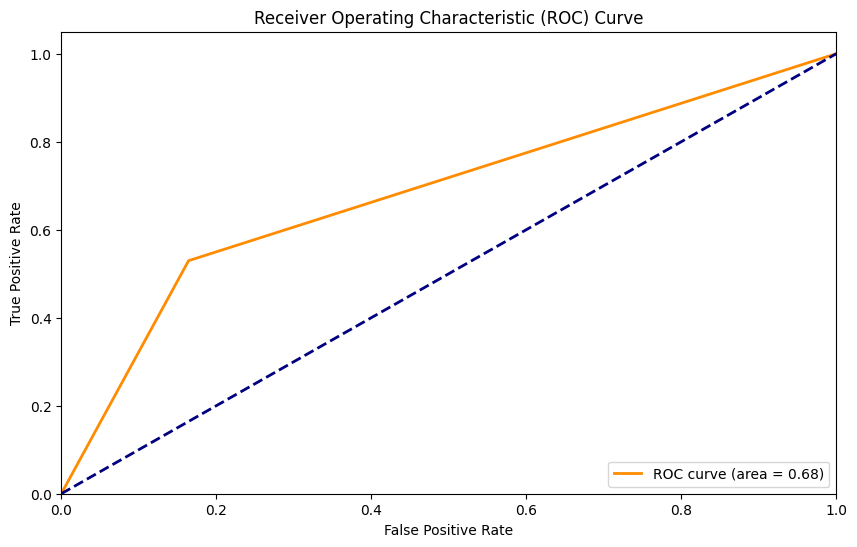

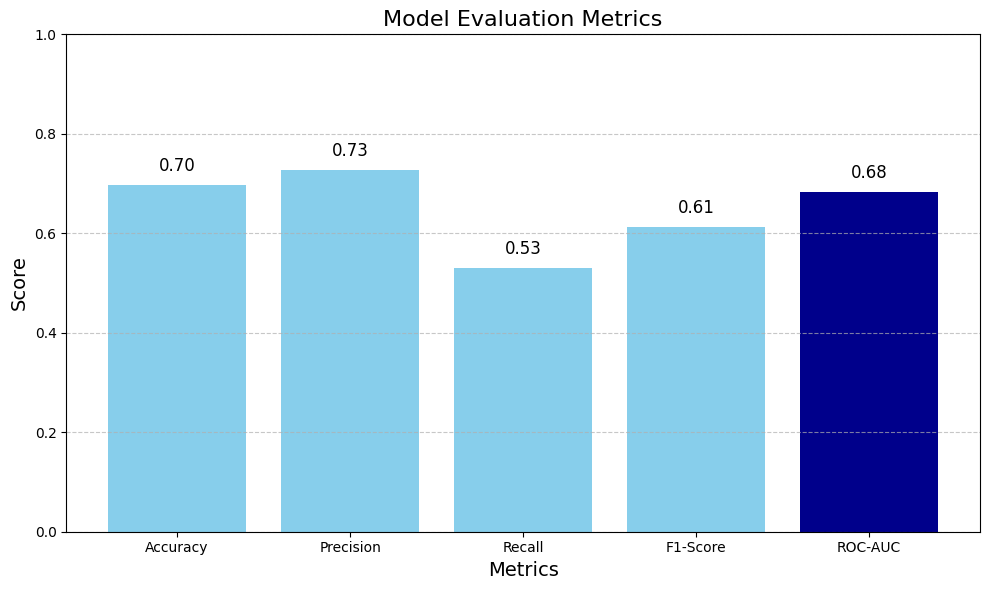

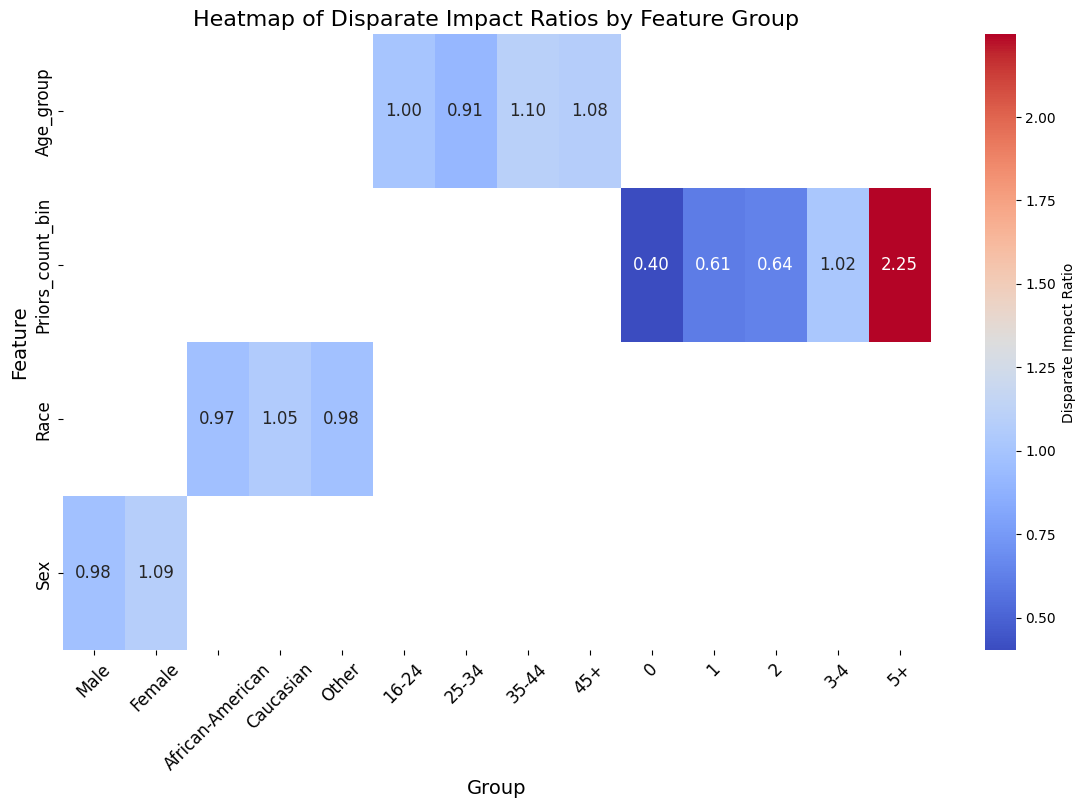

In [5]:
# Compute ROC AUC score
roc_auc_fair = roc_auc_score(y_test, y_pred_fair)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_fair)


# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_fair:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

import matplotlib.pyplot as plt


# Define the metrics and their respective scores
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
scores = [accuracy_fair, precision_fair, recall_fair, f1_fair, roc_auc_fair]

# Define colors for each metric
colors = ['skyblue', 'skyblue', 'skyblue', 'skyblue', 'darkblue']  # Dark blue for ROC-AUC

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, scores, color=colors)
plt.title('Model Evaluation Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text labels on top of each bar with increased font size
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, score + 0.02, f'{score:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example function to calculate disparate impact ratios
def calculate_disparate_impact(y_true, y_pred, X_test, column):
    disparate_impact_ratios = {}
    overall_favorable_outcomes = y_pred.mean()
    for value in X_test[column].unique():
        mask = X_test[column] == value
        # Ensure the mask matches the length of y_pred
        if len(mask) != len(y_pred):
            raise ValueError(f"Length mismatch: mask length {len(mask)} does not match y_pred length {len(y_pred)}")
        
        favorable_outcomes = y_pred[mask].mean()
        if overall_favorable_outcomes == 0:
            disparate_impact_ratios[value] = np.nan
        else:
            disparate_impact_ratios[value] = favorable_outcomes / overall_favorable_outcomes
    return disparate_impact_ratios


y_true = y_test

# List of features
features = ['sex', 'race', 'age_group', 'priors_count_bin']

# Calculate disparate impact ratios for each feature and group
disparate_impact_data = {
    'Feature': [],
    'Group': [],
    'Disparate Impact Ratio': []
}

for feature in features:
    disparate_impact_by_group = calculate_disparate_impact(y_true, y_pred_fair, X_test, feature)
    for group, ratio in disparate_impact_by_group.items():
        disparate_impact_data['Feature'].append(feature.capitalize())
        disparate_impact_data['Group'].append(group)
        disparate_impact_data['Disparate Impact Ratio'].append(ratio)

# Convert to DataFrame
disparate_impact_df = pd.DataFrame(disparate_impact_data)

# Pivot table for heatmap
disparate_impact_pivot = disparate_impact_df.pivot(index='Feature', columns='Group', values='Disparate Impact Ratio')

# Reordering columns for consistent plotting
group_order = ['Male', 'Female', 'African-American', 'Caucasian', 'Other', '16-24', '25-34', '35-44', '45+', '0', '1', '2', '3-4', '5+']
disparate_impact_pivot = disparate_impact_pivot[group_order]

# Plotting heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(disparate_impact_pivot, annot=True, cmap='coolwarm', cbar_kws={'label': 'Disparate Impact Ratio'}, annot_kws={'size': 12}, fmt=".2f")
plt.title('Heatmap of Disparate Impact Ratios by Feature Group', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()



## Serialization

In [7]:
TMP_DIR = ''

#Serialize the column names from the X DataFrame into a file named columns.json

with open(os.path.join(TMP_DIR, "columns.json"), 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)

# Pickle the dtypes of the columns from the X DataFrame into a file named dtypes.pickle

with open(os.path.join(TMP_DIR,'dtypes.pickle'), 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)
    
# Pickle the fitted pipeline into a file named pipeline.pickle

import joblib
import pickle
import gzip

# Compress the model
# Assuming 'pipeline' is your trained model or pipeline
with gzip.open('pipeline.pickle.gz', 'wb') as f:
    pickle.dump(pipeline, f)

## Testing the App

In [9]:
import requests
import json

url = "http://127.0.0.1:5000/will_recidivate"

data = {
         "id": "123456fagh1fw1",
        "name": "John Doe",
        "sex": "Male",
        "dob": "1990-01-01",
        "race": "Caucasian",
        "juv_fel_count": 2,
        "juv_misd_count": 1,
        "juv_other_count": 0,
        "priors_count": 5,
        "c_case_number": "A123456",
        "c_charge_degree": "F",
        "c_charge_desc": "Burglary",
        "c_offense_date": "2022-01-01",
        "c_arrest_date": "2022-01-02",
        "c_jail_in": "2022-01-03"
}

headers = {'Content-Type': 'application/json'}
r = requests.post(url, data=json.dumps(data), headers=headers)

print("Response status code:", r.status_code)
print("Response content:", r.text)

Response status code: 201
Response content: {
  "id": "123456fagh1fw1",
  "outcome": true
}



In [276]:
import requests

# Define the URL of your Flask application
url = 'http://127.0.0.1:5000/recidivism_result'  # Update with your actual URL

# Define the observation data
data = {
    "id": "54567fgvhb214g91f2162312",
    "outcome": True
}

headers = {'Content-Type': 'application/json'}
response = requests.post(url, data=json.dumps(data), headers=headers)

# Check the response status code
if response.status_code == 200:
    try:
        result = response.json()
        observation_id = result.get('id')  # Correct key
        outcome = result.get('outcome')  # Correct key
        predicted_outcome = result.get('predicted_outcome')  # Correct key
        if observation_id is not None and outcome is not None:
            print("Recidivism outcome updated successfully for ID:", observation_id)
            print("True outcome:", outcome)
            print("Predicted outcome:", predicted_outcome)
        else:
            print("Observation ID or outcome not found in the response")
    except ValueError:
        print("Failed to parse JSON response")
else:
    print("Failed to update recidivism outcome:", response.text)


Recidivism outcome updated successfully for ID: 54567fgvhb214g91f2162312
True outcome: True
Predicted outcome: False


In [ ]:
import requests

def test_will_recidivate():
    url = "https://capstone-production-fe3f.up.railway.app/will_recidivate"
    data = {
        "id": "123456a",
        "name": "John Doe",
        "sex": "Male",
        "dob": "1990-01-01",
        "race": "Caucasian",
        "juv_fel_count": 2,
        "juv_misd_count": 1,
        "juv_other_count": 0,
        "priors_count": 5,
        "c_case_number": "A123456",
        "c_charge_degree": "F",
        "c_charge_desc": "Burglary",
        "c_offense_date": "2022-01-01",
        "c_arrest_date": "2022-01-02",
        "c_jail_in": "2022-01-03"
    }

    try:
        response = requests.post(url, json=data)
        response.raise_for_status()  # Raise an error for bad status codes
        print(f"Status Code: {response.status_code}")
        print(response.json())
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        if response is not None:
            print(f"Status Code: {response.status_code}")
            print(response.text)

def test_recidivism_result():
    url = "https://capstone-production-fe3f.up.railway.app/recidivism_result"
    data = {
        "id": "123456a",
        "outcome": True
    }

    try:
        response = requests.post(url, json=data)
        response.raise_for_status()  # Raise an error for bad status codes
        print(f"Status Code: {response.status_code}")
        print(response.json())
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        if response is not None:
            print(f"Status Code: {response.status_code}")
            print(response.text)

def list_db_contents():
    url = "https://capstone-production-fe3f.up.railway.app/list-db-contents"

    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        print(f"Status Code: {response.status_code}")
        print(response.json())
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        if response is not None:
            print(f"Status Code: {response.status_code}")
            print(response.text)

# Run the tests
test_will_recidivate()
test_recidivism_result()
list_db_contents()

## Model comparation - COMAS vs New Model (visualizations)

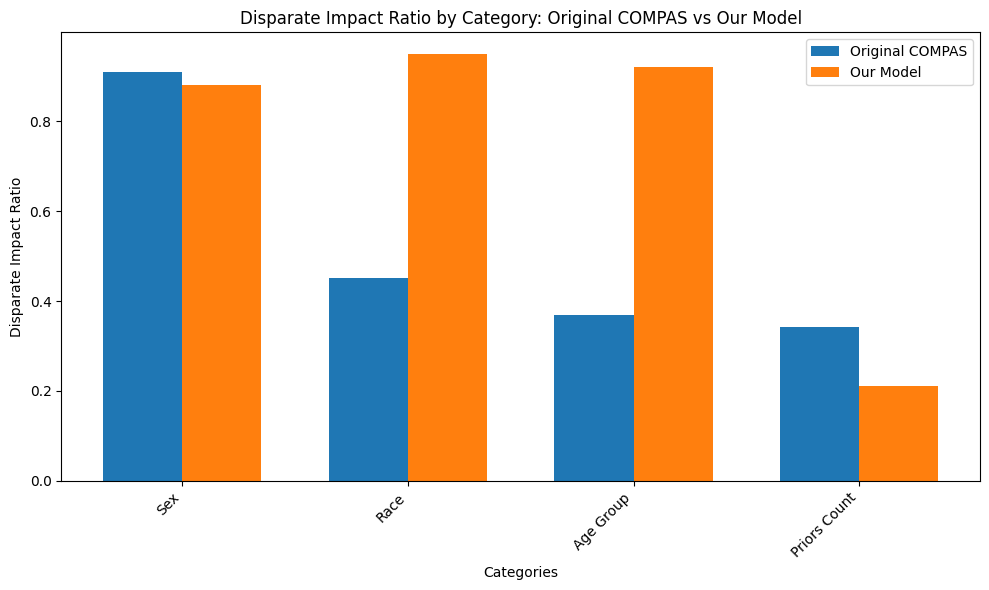

In [277]:
import matplotlib.pyplot as plt
import numpy as np

# Categories and their Disparate Impact Ratios for the original COMPAS and your new model
categories = ['Sex', 'Race', 'Age Group', 'Priors Count']

#These metrics results can be checked in EDA notebook
compas_disparate_impact = [0.909826, 0.451885, 0.368550, 0.342229]

#Results from chosen model
new_model_disparate_impact = [0.88, 0.95, 0.92, 0.21]

num_categories = len(categories)

x = np.arange(num_categories)

bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - bar_width/2, compas_disparate_impact, bar_width, label='Original COMPAS')
bars2 = ax.bar(x + bar_width/2, new_model_disparate_impact, bar_width, label='Our Model')

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('Categories')
ax.set_ylabel('Disparate Impact Ratio')
ax.set_title('Disparate Impact Ratio by Category: Original COMPAS vs Our Model')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()
